In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import myUtils
import EfficientNet
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from GTSRB_utils import GTSRB_CLASSES, predict_traffic_sign, create_subset_loader, load_ppm_image
from deep_fool import deepfool_attack


In [ ]:
# Direct download from original source (Institut für Neuroinformatik)
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip

# Unzip both files
!unzip GTSRB_Final_Training_Images.zip
!unzip GTSRB_Final_Test_Images.zip

# Cleanup (optional)
!rm *.zip

print("Dataset downloaded and extracted!")

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/Final_Test/Images/07633.ppm  
  inflating: GTSRB/Final_Test/Images/07634.ppm  
  inflating: GTSRB/Final_Test/Images/07635.ppm  
  inflating: GTSRB/Final_Test/Images/07636.ppm  
  inflating: GTSRB/Final_Test/Images/07637.ppm  
  inflating: GTSRB/Final_Test/Images/07638.ppm  
  inflating: GTSRB/Final_Test/Images/07639.ppm  
  inflating: GTSRB/Final_Test/Images/07640.ppm  
  inflating: GTSRB/Final_Test/Images/07641.ppm  
  inflating: GTSRB/Final_Test/Images/07642.ppm  
  inflating: GTSRB/Final_Test/Images/07643.ppm  
  inflating: GTSRB/Final_Test/Images/07644.ppm  
  inflating: GTSRB/Final_Test/Images/07645.ppm  
  inflating: GTSRB/Final_Test/Images/07646.ppm  
  inflating: GTSRB/Final_Test/Images/07647.ppm  
  inflating: GTSRB/Final_Test/Images/07648.ppm  
  inflating: GTSRB/Final_Test/Images/07649.ppm  
  inflating: GTSRB/Final_Test/Images/07650.ppm  
  inflating: GTSRB/Final_Test/Images/07651.ppm  
  inflating: GTSRB

In [5]:
from tensorflow.keras.models import load_model
model = load_model("EfficientNetB1.keras")

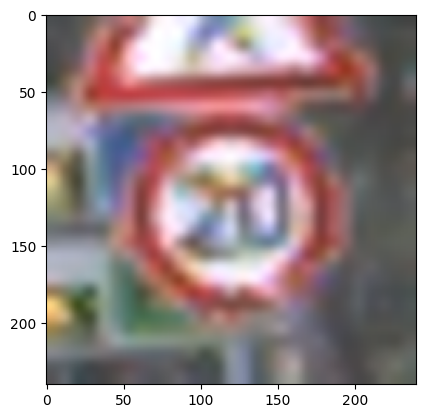

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Prediction shape: (1, 43)
Predicted class: Speed limit 20
True Prediction:  Speed limit 20


In [7]:

# Path to your .ppm image
image_path = "/content/GTSRB/Final_Training/Images/00000/00000_00000.ppm"

# Load and preprocess the image with the correct target size (240x240)
image = load_ppm_image(image_path, target_size=(240, 240))
image_to_show = tf.squeeze(image, axis=0)
plt.imshow(image_to_show/255.0)
plt.show()
true_pridition  = predict_traffic_sign(image, model, GTSRB_CLASSES)
print("True Prediction: ", GTSRB_CLASSES[true_pridition])

## DeepFool Attack

### Reference Paper for DeepFool

- **DeepFool: A Simple and Accurate Method to Fool Deep Neural Networks**  
  S.-M. Moosavi-Dezfooli, A. Fawzi, and P. Frossard, CVPR 2016  
  [arXiv:1511.04599](https://arxiv.org/abs/1511.04599)

### Usage of DeepFool

The `deepfool_attack_single` function implements DeepFool for a single image. It returns both the adversarial image and the perturbation applied.

Example:
```python
# Generate adversarial example
adv_image = deepfool_attack(
    model=model,
    img_input=image, #[0,255]
    num_classes=43,  # Replace with your class count
    clip_min=0.0,    # No normalization (0-255)
    clip_max=255.0
)
```

### ref
1. **DeepFool:**  
   Moosavi-Dezfooli, S.-M., Fawzi, A., & Frossard, P. (2016). DeepFool: A Simple and Accurate Method to Fool Deep Neural Networks. In *CVPR 2016*. [arXiv:1511.04599](https://arxiv.org/abs/1511.04599)




In [8]:
# Generate adversarial example
adv_image = deepfool_attack(
    model=model,
    img_input=image,
    num_classes=43,  # Replace with your class count
    clip_min=0.0,    # No normalization (0-255)
    clip_max=255.0
)

# Check prediction (model expects [0, 255] images)
prop = model.predict(adv_image)
pred_class = np.argmax(prop)
print("Adversarial class:", GTSRB_CLASSES[pred_class])

Initial prediction: Class 0

Iteration 0:
  Current class: 0

Iteration 1:
  Current class: 1

Attack succeeded at iteration 1!
Original class: 0 -> Adversarial class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Adversarial class: Speed limit 30


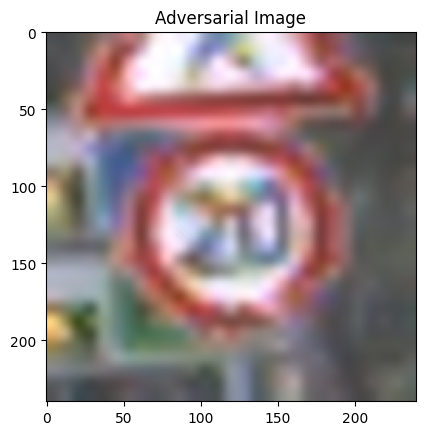

In [9]:
plt.imshow(tf.squeeze(adv_image, axis=0) / 255.0)
plt.title("Adversarial Image")
plt.show()


## SparseFool Attack

### Reference Paper for SparseFool

- **SparseFool: A Few Pixels Make a Big Difference**  
  Apostolos Modas, Seyed-Mohsen Moosavi-Dezfooli, Pascal Frossard, CVPR 2019  
  [arXiv:1811.02248](https://arxiv.org/abs/1811.02248)

### Methodology

SparseFool refines the adversarial perturbation found by DeepFool into a sparse perturbation by:
1. **Initial Adversarial Example:**  
   Running DeepFool to obtain a perturbation \( r_{\text{adv}} \) so that \( x_B = x + r_{\text{adv}} \) lies near the decision boundary.
2. **Estimating the Decision Boundary Normal:**  
   Computing the gradient at \( x_B \) to obtain the normal vector \( w \).
3. **Iterative Coordinate-Wise Updates:**  
   Updating one coordinate at a time:
   - **Select Coordinate:** Choose the coordinate with the largest absolute gradient value that isn’t saturated.
   - **Compute Perturbation:** Use the formula
     \[
     r_d = \frac{|w^T(x_{\text{current}} - x_B)|}{|w_d|} \cdot \text{sign}(w_d)
     \]
     to determine the minimal update needed along that coordinate.
   - **Apply Projection:** Update \( x_{\text{current}} \) with the computed perturbation and ensure the updated image stays within valid bounds.
   - **Accumulate Perturbation:** Add each coordinate update to the total perturbation \( r_{\text{total}} \).
   - **Stop When Misclassified:** Continue until the classifier misclassifies \( x_{\text{current}} \).

### Usage of SparseFool

Below is an example of how to use the `sparse_fool_attack` function on a single image:

```python

```



### References

 **SparseFool:**  
   Modas, A., Moosavi-Dezfooli, S.-M., & Frossard, P. (2019). SparseFool: A Few Pixels Make a Big Difference. In *CVPR 2019*. [arXiv:1811.02248](https://arxiv.org/abs/1811.02248)





In [ ]:
from sparsefool import sparsefool_attack

ModuleNotFoundError: No module named 'sparsefool'

In [19]:
# Generate adversarial example
adv_image = sparsefool_attack(
    model=model,
    img_input=image,  # Shape (1, H, W, C) in [0, 255]
    num_classes=10,
    top_k=200,  # Perturb 20 pixels per iteration
    epsilon=25.0,  # Larger perturbation per pixel
    verbose=True
)

# Check prediction
adv_prop = model.predict(adv_image)
print("Final class:", np.argmax(adv_prop[0]))

Initial prediction: Class 0
Iteration 0: Current class = 0
Iteration 1: Current class = 0
Iteration 2: Current class = 0
Iteration 3: Current class = 0
Iteration 4: Current class = 0
Iteration 5: Current class = 0
Iteration 6: Current class = 0
Iteration 7: Current class = 0
Iteration 8: Current class = 0
Iteration 9: Current class = 0
Iteration 10: Current class = 0
Iteration 11: Current class = 0
Iteration 12: Current class = 0
Iteration 13: Current class = 0
Iteration 14: Current class = 0
Iteration 15: Current class = 0
Iteration 16: Current class = 0
Iteration 17: Current class = 0
Iteration 18: Current class = 0
Iteration 19: Current class = 0
Iteration 20: Current class = 0
Iteration 21: Current class = 0
Iteration 22: Current class = 0
Iteration 23: Current class = 0
Iteration 24: Current class = 0
Iteration 25: Current class = 0
Iteration 26: Current class = 0
Iteration 27: Current class = 0
Iteration 28: Current class = 0
Iteration 29: Current class = 0
Iteration 30: Current 

In [21]:
# Generate adversarial example
adv_image = sparsefool_attack(
    model=model,
    img_input=image,  # Shape (1, H, W, C) in [0, 255]
    num_classes=43,
    top_k=100,  # Perturb 20 pixels per iteration
    epsilon=50.0,  # Larger perturbation per pixel
    verbose=True
)

# Check prediction
adv_prop = model.predict(adv_image)
print("Final class:", np.argmax(adv_prop[0]))

Initial prediction: Class 0
Iteration 0: Current class = 0
Iteration 1: Current class = 0
Iteration 2: Current class = 0
Iteration 3: Current class = 0
Iteration 4: Current class = 0
Iteration 5: Current class = 0
Iteration 6: Current class = 0
Iteration 7: Current class = 0
Iteration 8: Current class = 0
Iteration 9: Current class = 0
Iteration 10: Current class = 0
Iteration 11: Current class = 0
Iteration 12: Current class = 0
Iteration 13: Current class = 0
Iteration 14: Current class = 0
Iteration 15: Current class = 0
Iteration 16: Current class = 0
Iteration 17: Current class = 0
Iteration 18: Current class = 0
Iteration 19: Current class = 0
Iteration 20: Current class = 0
Iteration 21: Current class = 0
Iteration 22: Current class = 0
Iteration 23: Current class = 0
Iteration 24: Current class = 0
Iteration 25: Current class = 0
Iteration 26: Current class = 0
Iteration 27: Current class = 0
Iteration 28: Current class = 0
Iteration 29: Current class = 0
Iteration 30: Current 

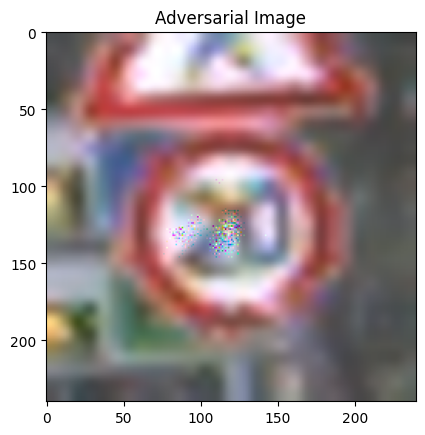

In [18]:
plt.imshow(tf.squeeze(adv_image, axis=0) / 255.0)
plt.title("Adversarial Image")
plt.show()